# Main Approaches for Dimensionality Reduction

there are two approaches of dimentionality reduction:- projection, mainfolding

projection - projecting the data into lower dimension

mainfolding - mainfold is basically a foldable hyperplane

there are different dimensionality reduction algorithms. the most popular ones are PCA, Kernel PCA and LLE

In [7]:
import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [8]:
X.shape

(60, 3)

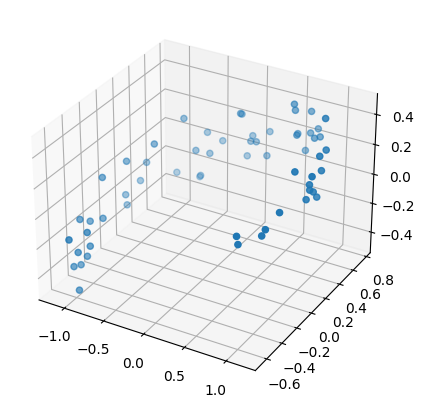

In [9]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize = (5,5))
ax = plt.axes(projection='3d')
x = X.T[0]
y = X.T[1]
z = X.T[2]
ax.scatter(x, y, z)
plt.show()

# PCA

uses projection method

we have to choose a hyperplane that preserves the maximum amount of variance

principal component - a unit vector that 

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

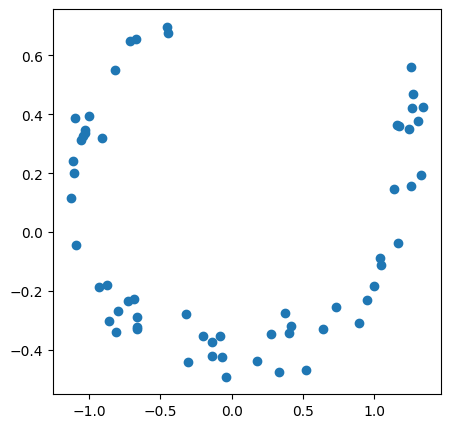

In [11]:
from mpl_toolkits import mplot3d
fig = plt.figure(figsize = (5,5))
ax = plt.axes()
x = X2D.T[0]
y = X2D.T[1]
ax.scatter(x, y)
plt.show()

## Choosing the Right Number of Dimensions

In [12]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [15]:
X_train.shape

(52500, 784)

The following code performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of the training set’s variance

In [19]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [34]:
d

154

here, the dimension is reduced from 784 to 154

but there is a better way, just indicate the ratio of variance you wish to preserve

In [27]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

we can also use explained_variance_ration_ to decide the number of dimensions. just plot cumsum

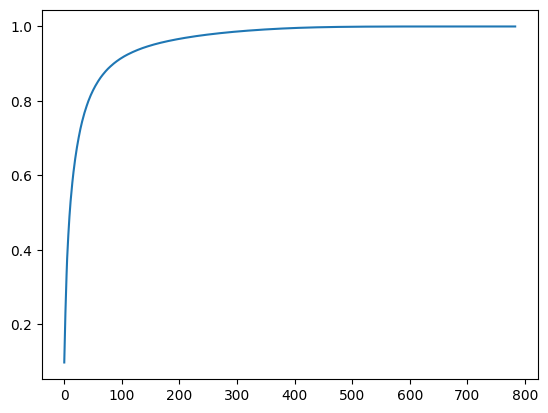

In [30]:
plt.plot(cumsum)

compressing and decompressing data

In [22]:
pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

the error between original data and decompressed data is called reconstraction error

### Randomized PCA

scikit-learn uses stochastic algorithm called Randomized PCA for quicker approximation

In [35]:
rnd_pca = PCA(n_components=154, svd_solver="randomized")
X_reduced = rnd_pca.fit_transform(X_train)

By default, svd_solver is actually set to "auto": Scikit-Learn
automatically uses the randomized PCA algorithm if m or n is greater than 500 and d is less than 80% of m or n, or else it uses the full SVD approach. If you want to force Scikit-Learn to use full SVD, you can set the svd_solver hyperparameter to "full".

### Incremental PCA

Uses similiar techniques to mini-batch gradient descent to feed an IPCA algorithm one mini-batch at a time. This is useful for large datasets and online PCA

unlike the previous implementations of PCA, it doesn't require the whole training set to fit in memory

Note that you must call the partial_fit() method with each mini-batch, rather than the fit() method with the whole training set:

In [36]:
from sklearn.decomposition import IncrementalPCA
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)

# Kernel PCA

Employs a technique similar to the kernels in SVM

In [ ]:
from sklearn.decomposition import KernelPCA
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

### Selecting a Kernel and Tuning Hyperparameters

method 1 - grid search for best kernel and hayperparameters

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
clf = Pipeline([
        ("kpca", KernelPCA(n_components=2)),
        ("log_reg", LogisticRegression())
    ])
param_grid = [{
        "kpca__gamma": np.linspace(0.03, 0.05, 10),
        "kpca__kernel": ["rbf", "sigmoid"]
    }]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

In [ ]:
grid_search.best_params_

method 2 - select the kernel and hyperparameter that yields the lowest reconstraction error.

In [ ]:
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)
X_preimage = rbf_pca.inverse_transform(X_reduced)

we can compute the reconstraction pre-image error

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

# LLE

It is Mainfold Learning technique

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)